In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  # Correlation-Based Clustering Methods
from datetime import datetime

# Load dataset

In [47]:
print("Loading")
train = pd.read_csv('data/data_format1/train_format1.csv').drop_duplicates()
test = pd.read_csv('data/data_format1/test_format1.csv').drop_duplicates()
user_info = pd.read_csv('data/data_format1/user_info_format1.csv').drop_duplicates()
user_log = pd.read_csv('data/data_format1/user_log_format1.csv')
print("Load success")

Loading
Load success


<b>1. Train data</b>
<ul>
<li>user_id</li>
<li>merchant_id</li>
<li>label: '1' denotes 'user_id' is a repeat buyer for 'merchant_id', while '0' is the opposite. </li>
</ul>

In [3]:
train.head(3)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1


<b>2. Teat data</b>
<ul>
<li>user_id</li>
<li>merchant_id</li>
<li>prob: probability </li>
</ul>

In [4]:
test.head(3)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN


<b>3. User information data</b>
<ul>
<li>user_id</li>
<li>age_range: 1 for [,18];
            2 for [18,24];  
            3 for [25,29];  
            4 for [30,34]; 
            5 for [35,39]; 
            6 for [40,49]; 
            7 and 8 for >= [50,];
0 and NULL for unknown.</li>
<li>gender:  0 for female, 1 for male, 2 and NULL for unknown.</li>
</ul>

In [5]:
user_info.head(3)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0


<b>4. User Log data</b>
<ul>
<li>user_id</li>
<li>item_id: goods</li>
<li>cat_id: category</li>
<li>seller_id: merchant_id</li>
<li>brand_id</li>
<li>time_stamp: mmdd</li>
<li>action_type: 0 is for click, 1 is for add-to-cart, 2 is for purchase and 3 is for add-to-favourite</li>
</ul>

In [6]:
user_log.head(3)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0


# Data Cleaning
## A. Drop all nan and rename
1. Drop nan  
2. Rename seller_id to merchant_id  
In user_log, "seller_id" should be called as "merchant_id".  
It is a mistake by data provider.  
3. Divide time_stamp into mm,dd two columns

In [48]:
user_info.dropna(axis=0,how='all',inplace = True)
user_log.dropna(axis=0,how='all',inplace = True)

In [49]:
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [50]:
user_log['time_mm'] = user_log['time_stamp'] // 100
user_log['time_dd'] = user_log['time_stamp'] % 100

## B. Deal with missing value
### Find out missing colunms

In [51]:
def num_missing(x):
  return sum(x.isnull())

In [10]:
print("Missing values per column:")
print("Train data missing: \n", train.apply(num_missing, axis=0),'\n')
print("User_info data missing: \n", user_info.apply(num_missing, axis=0),'\n')
print("User_log data missing: \n", user_log.apply(num_missing, axis=0))

Missing values per column:
Train data missing: 
 user_id        0
merchant_id    0
label          0
dtype: int64 

User_info data missing: 
 user_id         0
age_range    2217
gender       6436
dtype: int64 

User_log data missing: 
 user_id            0
item_id            0
cat_id             0
merchant_id        0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64


### For User_info data
1. Observation of "age_range" and "gender" in histogram.

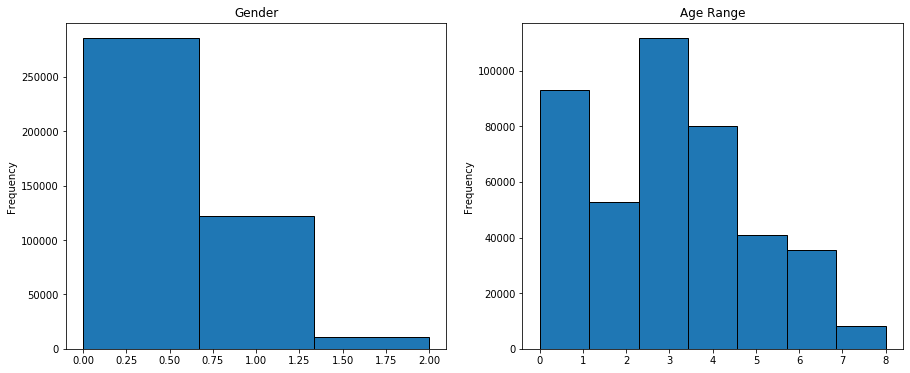

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 6), sharey=False)
user_info['gender'].plot.hist(ax=axes[0],bins=3,edgecolor='black', title="Gender")
user_info['age_range'].plot.hist(ax=axes[1],bins=7,edgecolor='black', title="Age Range")

2. Drop empty "gender" and "age_range" data

In [52]:
# fillna by by previous value
# user_info.fillna(method='ffill',inplace=True)
# dropna
user_info['age_range'] = user_info['age_range'].fillna(value=0)
user_info.dropna(subset=['gender'],inplace=True)

3. Check result.  

In [11]:
print("User_info data missing: \n", user_info.apply(num_missing, axis=0),'\n')

User_info data missing: 
 user_id      0
age_range    0
gender       0
dtype: int64 



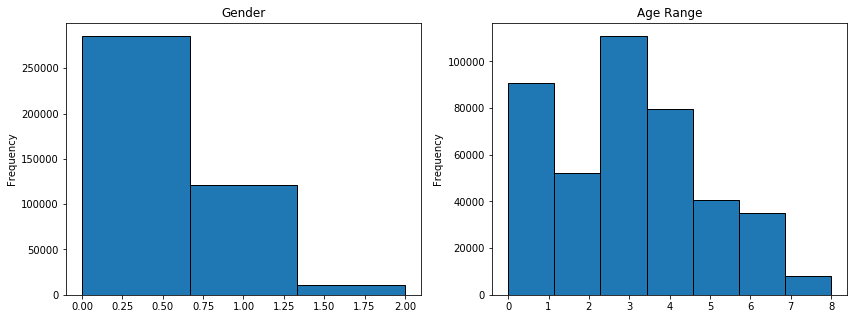

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 5), sharey=False)
user_info['gender'].plot.hist(ax=axes[0],bins=3,edgecolor='black', title="Gender")
user_info['age_range'].plot.hist(ax=axes[1],bins=7,edgecolor='black', title="Age Range")

### For User_log data
1. Principle: One brand contains multi items, but one item only belongs to one brand.

In [15]:
# Test relationship/principle
user_log[['item_id','brand_id']][user_log['item_id']==239288].head(3)

,item_id,brand_id
10,239288,4953.0
40817,239288,4953.0
55038,239288,4953.0


In [16]:
# Also have some items does not have brand_id
user_log[['item_id','brand_id']][user_log['item_id']==157368].head()

,item_id,brand_id
32109,157368,NaN


2. Fill missing value  
We can see that after fill lots of brand_id, user_log still has missing brand_id.
Some items don't have a mapped brand_id.

In [53]:
item_brand_dict = user_log.drop_duplicates(subset=['item_id','brand_id']).set_index('item_id')['brand_id'].to_dict()
user_log[user_log['brand_id'].isna()] = user_log[user_log['brand_id'].isna()].apply(lambda x: x.fillna(item_brand_dict[x['item_id']]), axis=1)
print("Done")

Done


4. Check the result.

In [18]:
print("In User_log, 'brand_id' still missing: \n", len(user_log[user_log['brand_id'].isna()]))

In User_log, 'brand_id' still missing: 
 86604


### Change Data Type
Save some space/memory

In [54]:
user_info[['age_range','gender']] = user_info[['age_range','gender']].astype('Int8')  # int8 : (from -128 to 127)
user_log[['user_id','item_id','cat_id']] = user_log[['user_id','item_id','cat_id']].astype('Int64')
user_log[['merchant_id','brand_id','time_stamp']] = user_log[['merchant_id','brand_id','time_stamp']].astype('Int16')
user_log[['action_type']] = user_log[['action_type']].astype('Int8')

In [20]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417734 entries, 0 to 424169
Data columns (total 3 columns):
user_id      417734 non-null int64
age_range    417734 non-null Int8
gender       417734 non-null Int8
dtypes: Int8(2), int64(1)
memory usage: 8.0 MB


In [21]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
user_id        Int64
item_id        Int64
cat_id         Int64
merchant_id    Int16
brand_id       Int16
time_stamp     Int16
action_type    Int8
dtypes: Int16(3), Int64(3), Int8(1)
memory usage: 2.4 GB


# Feature Extraction
## A. Method

In [55]:
def feature_extract(df:pd.DataFrame, cols, grop, aggs, rname, types):
    if types == 'cnt':
        return df[cols].groupby(grop, as_index=False).count().rename(columns=rname)
    
    if types == 'sub_agg':
        return df.groupby(grop, as_index=False).agg(aggs).rename(columns=rname)

In [56]:
def max_min_normalization(df:pd.DataFrame):
    return (df-df.min())/(df.max()-df.min())

In [57]:
def time_diff(t):
    return (datetime.strptime(str(max(t)), '%m%d') - datetime.strptime(str(min(t)), '%m%d')).days

### For User

In [58]:
f_user = pd.DataFrame(user_log['user_id']).drop_duplicates()

For each user_id:  
1. Integrate user_info,  age_range and gender.

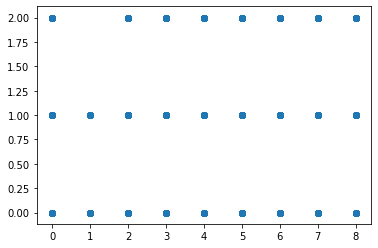

In [23]:
plt.scatter(user_info['age_range'], user_info['gender'])

In [59]:
kmeans = KMeans(init='k-means++', n_clusters=23) # the number of 23 is from the graph above
f_u_ag = kmeans.fit_predict(user_info[['age_range','gender']])
user_info['f_u_ag'] = f_u_ag
f_user = pd.merge(f_user, user_info, on=['user_id'], how='left')
# f_user = user_info.drop(columns=['age_range','gender'])
user_info.drop(columns=['f_u_ag'], inplace=True)

For each user_id:  
2. Extract the count of action_types
3. Extract the count of merchant_id  
4. Extract the count of item_id  
5. Extract the count of cat_id(categary)  
5. Extract the count of brand_id

用户每天交互、购买的次数
用户每月交互、购买的次数

In [60]:
print('------Start------')

f_temp = feature_extract(user_log,['user_id','action_type'],['user_id'],None,{'action_type':'f_u_action'},'cnt')
f_user = pd.merge(f_user, f_temp, on=['user_id'])

aggs = {'merchant_id':lambda x: len(set(x)), 
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'merchant_id':'f_u_merchant','item_id':'f_u_item','cat_id':'f_u_cat','brand_id':'f_u_brand'}
f_temp = feature_extract(user_log, None, ['user_id'], aggs, rnames, 'sub_agg')
f_user = pd.merge(f_user, f_temp, on=['user_id'])

print('------Done------')

------Start------
------Done------


In [62]:
f_user

,user_id,age_range,gender,f_u_ag,f_u_action,f_u_merchant,f_u_item,f_u_cat,f_u_brand
0,328862,6,1,6.0,419,58,293,46,61
1,234512,5,0,0.0,56,21,29,18,20
2,356311,5,0,0.0,157,28,96,22,28
3,272389,6,1,6.0,26,5,23,9,5
4,139859,7,0,14.0,43,24,30,22,23
...,...,...,...,...,...,...,...,...,...
424165,29504,0,1,10.0,22,9,14,7,9
424166,125763,0,1,10.0,95,4,27,12,3
424167,128038,2,0,1.0,33,12,16,6,12
424168,34885,0,1,10.0,18,5,5,3,5


In [75]:
f_user[['f_u_ag','f_u_action','f_u_merchant','f_u_item','f_u_cat','f_u_brand']] = max_min_normalization(f_user.drop(columns='user_id'))


In [85]:
pca = PCA(n_components=6)
pca.fit(f_user.drop(columns='user_id'))

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [87]:
X = pca.transform(f_user.drop(columns='user_id'))

In [89]:
X

array([[ 2.77621295e-01, -2.04059575e-02, -5.54307347e-04,
         6.69312813e-04,  4.95708754e-04, -9.03057429e-05],
       [-1.76900253e-01, -1.67620248e-02, -4.65390548e-03,
        -9.56501419e-04,  6.94688837e-04,  4.27013675e-04],
       [-1.76793426e-01, -1.91195151e-03, -1.28793957e-02,
         3.83098960e-03, -1.83388813e-04, -2.18956202e-04],
       ...,
       [ 2.32072232e-01, -3.98293388e-02, -1.51573308e-03,
         3.35817988e-03,  1.38511214e-04, -2.97825765e-04],
       [ 2.77466809e-01, -4.40855527e-02,  8.72072467e-03,
        -9.89946312e-04,  4.87318192e-04, -1.22761883e-04],
       [-8.62413304e-02, -5.76991315e-02,  8.02118319e-03,
         2.61153147e-03,  4.55631959e-04, -2.79215949e-04]])

In [90]:
pca.explained_variance_ratio_

array([9.00106535e-01, 8.94676240e-02, 6.78838807e-03, 3.27955597e-03,
       3.16023962e-04, 4.18733619e-05])

In [91]:
pca.singular_values_

array([105.10212664,  33.1358029 ,   9.12741668,   6.34412994,
         1.96935746,   0.71685854])

### For Merchant

For each merchant:

1. Extract the count of action_types
2. Extract the count of user_id
3. Extract the count of item_id
4. Extract the count of cat_id(categary)
5. Extract the count of brand_id   
商铺下有多少被交互的商品，商品类别和商品品牌数量  
商铺每个月有多少用户交互  
商铺下交互的用户按年龄段和性别分别统计  
商铺在各个年龄段和性别组合的交互用户中交互的商品、商品类别和商品品牌总数  
商铺在各个年龄段和性别组合的购买用户中购买的商品、商品类别和商品品牌总数

In [63]:
f_merchant = pd.DataFrame(user_log['merchant_id']).drop_duplicates()

In [64]:
print('------Start------')

f_temp = feature_extract(user_log,['merchant_id','action_type'],['merchant_id'],None,{'action_type':'f_m_action'},'cnt')
f_merchant = pd.merge(f_merchant, f_temp, on=['merchant_id'])

aggs = {'user_id':lambda x: len(set(x)), 
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'user_id':'f_m_user','item_id':'f_m_item','cat_id':'f_m_cat','brand_id':'f_m_brand'}
f_temp = feature_extract(user_log, None, ['merchant_id'], aggs, rnames, 'sub_agg')
f_merchant = pd.merge(f_merchant, f_temp, on=['merchant_id'])

print('------Done------')

------Start------
------Done------


In [66]:
f_merchant

,merchant_id,f_m_action,f_m_user,f_m_item,f_m_cat,f_m_brand
0,2882,9416,2362,491,6,2
1,1253,51919,11817,1047,10,5
2,883,45636,4935,1082,19,3
3,420,213754,26642,1444,21,7
4,4605,56943,15605,223,31,2
...,...,...,...,...,...,...
4990,2408,784,127,120,18,2
4991,2979,143,47,13,3,1
4992,3808,235,140,11,4,1
4993,3532,572,154,50,8,1


In [112]:
f_merchant[['f_m_action','f_m_user','f_m_item','f_m_cat','f_m_brand']] = max_min_normalization(f_merchant.drop(columns='merchant_id'))


SyntaxError: invalid syntax (<ipython-input-112-b12d6daed545>, line 1)

### For Category

For each category

1. Extract the count of action_types
2. Extract the count of user_id
3. Extract the count of merchant_id
4. Extract the count of item_id
5. Extract the count of brand_id

In [67]:
f_cat = pd.DataFrame(user_log['cat_id']).drop_duplicates()

In [69]:
print('------Start------')

f_temp = feature_extract(user_log,['cat_id','action_type'],['cat_id'],None,{'action_type':'f_c_action'},'cnt')
f_cat = pd.merge(f_cat, f_temp, on=['cat_id'])

aggs = {'user_id':lambda x: len(set(x)), 
        'merchant_id':lambda x: len(set(x)),
        'item_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'user_id':'f_c_user','merchant_id':'f_c_merchant','item_id':'f_c_item','brand_id':'f_c_brand'}
f_temp = feature_extract(user_log, None, ['cat_id'], aggs, rnames, 'sub_agg')
f_cat = pd.merge(f_cat, f_temp, on=['cat_id'])

print('------Done------')

------Start------
------Done------


In [71]:
f_cat

,cat_id,f_c_action,f_c_user,f_c_merchant,f_c_item,f_c_brand
0,833,100659,31521,304,2691,319
1,1271,660025,111493,366,14727,398
2,1467,796754,115972,431,21434,489
3,1095,1155256,161674,696,24794,769
4,602,1248070,113834,186,10052,185
...,...,...,...,...,...,...
1653,473,1,1,1,1,1
1654,911,1,1,1,1,1
1655,1572,2,1,2,2,1
1656,540,1,1,1,1,1


### For Brand

For each Brand

1. Extract the count of action_types
2. Extract the count of user_id
3. Extract the count of merchant_id
4. Extract the count of item_id
5. Extract the count of cat_id

In [74]:
f_brand = pd.DataFrame(user_log['brand_id']).drop_duplicates().dropna()

In [75]:
print('------Start------')

f_temp = feature_extract(user_log,['brand_id','action_type'],['brand_id'],None,{'action_type':'f_b_action'},'cnt')
f_brand = pd.merge(f_brand, f_temp, on=['brand_id'])

aggs = {'user_id':lambda x: len(set(x)), 
        'merchant_id':lambda x: len(set(x)),
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x))}
rnames = {'user_id':'f_b_user','merchant_id':'f_b_merchant','item_id':'f_b_item','cat_id':'f_b_cat'}
f_temp = feature_extract(user_log, None, ['brand_id'], aggs, rnames, 'sub_agg')
f_brand = pd.merge(f_brand, f_temp, on=['brand_id'])

print('------Done------')

------Start------
------Done------


In [76]:
f_brand

,brand_id,f_b_action,f_b_user,f_b_merchant,f_b_item,f_b_cat
0,2661,9428,2370,2,504,6
1,1049,8652,3447,1,213,5
2,1647,45605,4933,1,1081,19
3,4953,133462,21289,1,598,14
4,7622,56936,15613,5,245,23
...,...,...,...,...,...,...
8438,1679,2,1,1,2,1
8439,244,1,1,1,1,1
8440,7838,1,1,1,1,1
8441,6376,1,1,1,1,1


In [42]:
f_user_merchant

,user_id,merchant_id
0,34176,3906
1,34176,121
2,34176,4356
3,34176,2217
4,230784,4818
...,...,...
260859,359807,4325
260860,294527,3971
260861,294527,152
260862,294527,2537


In [45]:
train[train['user_id'].isin(test['user_id'].tolist())]

,user_id,merchant_id,label


In [21]:
test

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN
...,...,...,...
261472,228479,3111,NaN
261473,97919,2341,NaN
261474,97919,3971,NaN
261475,32639,3536,NaN


In [ ]:
user_log

In [49]:
train[train['user_id']==163968]

,user_id,merchant_id,label


In [37]:
a = user_log['user_id']+user_log['merchant_id']
a = a.drop_duplicates()

In [39]:

b = test['user_id']+test['merchant_id']
b = b.drop_duplicates()

In [44]:
cnt = 0
for i in c:
    if i in a:
        cnt = cnt+1

print(cnt) 

40472


In [41]:
c = train['user_id']+train['merchant_id']
c = b.drop_duplicates()